# Import useful functions

In [2]:
# TODO: 
# r_d (sound horizon at the drag epoch) might need to be determined by camb.
# for now z_d is a constant - should I calculate it exactly?
# Check exactly for z_nucleosynthesis
# alpha_t lower limit for now is prior from Clifton review

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd
from astropy.table import Table
import scipy

# Defining equations in our theory

In [3]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    # small alpha approximation to deal with numerical instabilities
    elif alpha_tilde < 1e-10 and E_L < 1e4:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2 - alpha_tilde* (E_L**2)/4)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans


In [4]:
# ------ equations for BAO ------ c = 1

# Angular diameter distance
def D_M_H0(z,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = chi
    return D

# Hubble distance
def D_H_H0(z,cosmo):
    D = np.zeros(len(z))
    for i in range(len(z)):
        D[i] = 1/E(z[i],cosmo)
    return D

# Spherically-averaged distance (historical BAO distance)
def D_V_H0(z,cosmo):
    return (z*D_H_H0(z,cosmo)*D_M_H0(z,cosmo)**2)**(1/3)

# redshift at drag epoch - for now assume a LCDM constant from Komatzu et al 2009
# See https://arxiv.org/pdf/1306.3208.pdf Appendix B to find value exactly at a given parameter (this is quite involved) 
def z_d():
    return 1020.5

# Used to find r_s - only works for 0.0025 < wb < 0.25 and 0.025 < wm < 0.64 
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Note that we assumed sound horizon was zero at the end of nucleosynthesis
def r_d_H0(cosmo,h):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omega_b*h**2)*x))), 1e-28, 1/(1+z_d()))[0]

In [5]:
# ------ equations for SNe -----

# Equations for mu

# Luminosity distance
def D_L(z,cosmo,H0):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    c = 3e5
    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = (c*(1+z[i])/H0)*np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = (c*(1+z[i])/H0)*np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = (c*(1+z[i])/H0)*chi
    return D

# dl has units of Mpc
def mu(dl):
    return 5*np.log10(dl/1e-5)

# Likelihoods

In [6]:
# Log likelihood for SNe data 

def log_likelihood_SNe(theta, z, y, cov):
    Omg_c, Omg_b, h, alpha_t = theta
    
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    cosmo = [Omg_c , Omg_b , 0 , Omg_r , alpha_t,0]
    if X(4e8 , cosmo) <= 1e-4 or (np.sqrt(X(4e8 , cosmo)) - 1)/(2 * alpha_t) <= 1e-4:
        return -np.inf
    model = np.array(mu(D_L(z, cosmo, 100*h)))
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

In [7]:
# SPECIFIC TO MGS DATA (1)
# takes a dataframe with chisquared and D_V/D_{V,fid}*r_{d,fid}/r_d 
# and returns a likelihood for a given theta

def log_likelihood_MGS(theta , df):
    z =  [0.15,0.15] # use array just because I've been using arrays in other functions. at the end select [0]
    Omg_c, Omg_b, h, alpha_t = theta

    Omg_r = (2.47e-5*h**-2)*1.6949484
    D_V_fid_MGS = 638.95 # Mpc
    r_d_fid_MGS = 148.69 # Mpc
    likelihood_tointerpolate = np.array(-df["chisquared"]/2)
    D_V_rd_tointerpolate = np.array(df["D_V_etc"])*D_V_fid_MGS/r_d_fid_MGS
    D_V_rd_theory = D_V_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    return np.interp(D_V_rd_theory, D_V_rd_tointerpolate, likelihood_tointerpolate)[0]

In [8]:
# SPECIFIC TO LRG DATA (2), (3b) and (3c)
# takes a dataframe with z, D_M(zeff)/r_d and D_H(zeff)/r_d and a dataframe with covariances
# and returns a likelihood for a given theta 

def log_likelihood_DMDH(theta , df , df_cov): # data = y, DM_or_DH
    Omg_c, Omg_b, h, alpha_t = theta

    Omg_r = (2.47e-5*h**-2)*1.6949484
    
    z = np.array(df[0])
    y = np.array(df[1])
    cov = np.matrix(df_cov)
    model = np.zeros(len(z))
    
    for i in range(len(z)):
        if df[2][i] == "DM_over_rs":
            # Note: I did some trickery because z is meant to be an array
            model[i] = D_M_H0([z[i],z[i]],[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
        else:
            model[i] = D_H_H0([z[i],z[i]],[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    model = np.array(model)
    return -0.5 * float(np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model)))

In [9]:
# SPECIFIC TO DR16 ELG DATA (3a)
# takes a dataframe with D_V(zeff)/r_d at zeff = 0.845 and the normalized likelihood
# and returns a likelihood for a given theta

def log_likelihood_DR16_ELG(theta , df):
    z =  [0.845,0.845] # use array just because I've been using arrays in other functions. at the end select [0]
    Omg_c, Omg_b, h, alpha_t = theta

    Omg_r = (2.47e-5*h**-2)*1.6949484
    
    likelihood_tointerpolate = np.array(df[1])
    D_V_rd_tointerpolate = np.array(df[0])
    D_V_rd_theory = D_V_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    return np.log(np.interp(D_V_rd_theory, D_V_rd_tointerpolate, likelihood_tointerpolate)[0])

In [10]:
# SPECIFIC TO DR16 LYA DATA (4)
# takes a dataframe with D_M(zeff)/r_d or D_H(zeff)/r_d at zeff = 2.334 and the normalized likelihood
# and returns a likelihood for a given theta

def log_likelihood_DR16_LYA(theta , df):
    z =  [2.334,2.334] # use array just because I've been using arrays in other functions. at the end select [0]
    Omg_c, Omg_b, h, alpha_t = theta

    Omg_r = (2.47e-5*h**-2)*1.6949484
    
    likelihood_tointerpolate = np.array(df["likelihood_ratio"])
    D_H_rd_tointerpolate = np.array(df["D_H(z=2.334)/r_d"])
    D_H_rd_theory = D_H_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    D_M_rd_tointerpolate = np.array(df["D_M(z=2.334)/r_d"])
    D_M_rd_theory = D_M_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])[0]/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    
    interp = scipy.interpolate.LinearNDInterpolator(list(zip(D_H_rd_tointerpolate, D_M_rd_tointerpolate)), likelihood_tointerpolate)
    ans = float(interp(D_H_rd_theory, D_M_rd_theory))
    if np.isnan(ans) == True:
        return 0.0
    else:
        return ans

In [11]:
def log_prior(theta):
    Omg_c, Omg_b, h, alpha_t = theta

    wb = Omg_b*h**2
    wm = (Omg_c + Omg_b)*h**2
    if 0.025 < wm < 0.64 and 0.0025 < wb < 0.25 and 0 < Omg_c < 1 and 0 < h < 1 and -1e-50 < alpha_t < 1 :
        return 0.0
    return -np.inf

In [12]:
def log_probability(theta, x, y, sigma):
    lp = log_prior(theta)
    x_SNe = x
    y_SNe, df_MGS, df_DR12, df_DR16_ELG, df_DR16_LRG, df_DR16_QSO, df_DR16_LYA_auto, df_DR16_LYA_cross = y
    cov_SNe, df_cov_DR12, df_cov_DR16_LRG, df_cov_DR16_QSO = sigma
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_SNe(theta, x_SNe, y_SNe, cov_SNe)\
            +log_likelihood_MGS(theta,df_MGS)+log_likelihood_DR16_ELG(theta , df_DR16_ELG)\
            + log_likelihood_DR16_LYA(theta , df_DR16_LYA_auto) + log_likelihood_DR16_LYA(theta , df_DR16_LYA_cross)\
            +log_likelihood_DMDH(theta , df_DR12, df_cov_DR12) + log_likelihood_DMDH(theta, df_DR16_QSO,df_cov_DR16_QSO) \
            + log_likelihood_DMDH(theta, df_DR16_LRG,df_cov_DR16_LRG) \


# NOTE: DR12, DR16QSO and DR16LRG data give strange error. This doesn't occur if we change the covariance matrix (ex. make it diagonal). Ask Danielle

# Getting the data

## SNe data

The data we will use for SNe data come from  Betoule+2014 (https://arxiv.org/pdf/1401.4064.pdf) and can be downloaded from http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html. This is the data that Planck 2015 used to test alternatives to LCDM.

In [13]:
#import data for SNe

# get the data

# data values for z_b, mu_b
tab_vals = Table.read(r'~/Desktop/Newcastle/4DEGB/Data/SneTable.tex')

# covariance matrix for our data - NOTE MISS FACTOR OF 10^-6
tab_cov = Table.read(r'/home/c2042999/Desktop/Newcastle/4DEGB/Data/SneTable_covmat.tex')

# get it in matrix form
tab_cov = np.lib.recfunctions.structured_to_unstructured(tab_cov.as_array())
tab_cov = tab_cov.filled(0)
# get the correct symmetric format
tab_cov = 1e-6 * (np.rot90(np.fliplr(tab_cov)) + tab_cov - np.diag(np.diag(tab_cov)))

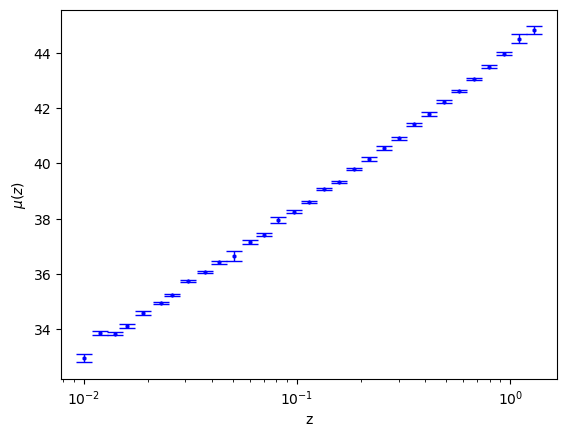

In [14]:
# Plot data SNe

x_SNe = np.array(tab_vals["$z_b$"])
cov_SNe = tab_cov
y_SNe = np.array(tab_vals["$\mu_b$"])

plt.errorbar(x_SNe, y_SNe, yerr=np.array(np.sqrt(np.diag(cov_SNe))),ls = "none", linewidth=1, capsize=6, color = "b")
plt.scatter(x_SNe, y_SNe, s = 5, marker = "h", color = "b")

plt.xlabel("z")
plt.ylabel(r"$\mu(z)$");
plt.xscale("log")

## BAO data

The data we will use is the same as that used in DESY3 results: DE and MG paper.

This is the data we will use (explanation taken from Alam+2020 THE COMPLETED SDSS-IV EXTENDED BOSS). All data from https://svn.sdss.org/public/data/eboss/DR16cosmo/tags/v1_0_0/likelihoods/BAO-only/ and saved locally in SDSS_BOSS_data
1. Main Galaxy Sample (MGS): 

    a. Ross+2015 https://arxiv.org/pdf/1409.3242.pdf 
    
    b. data from arxiv .dat file. Saved locally as chid_MGSconsensus.dat
    
    c. Gives us D_V_etc = $D_V/D_{V,fid} \times r_{d,fid}/r_d$
    
    d. For our fiducial cosmology (Flat, Omega_matter=0.31, h =0.67), $D^{\rm fid}_V(z) = 638.95$ Mpc and $r_d^{\rm fid} = 148.69$ Mpc.

    
2. BOSS DR12 Galaxies (BOSS Galaxies) - DR12_LRG: 

    a. Alam+2017 https://arxiv.org/pdf/1607.03155.pdf table 7 (BAO-only)
    
    b. "These results were computed over all three redshift intervals after fully accounting for systematic errors and covariances between parameters and between redshift bins"
    
    c. Gives us $D_M \times r_{d,fid}/r_d$ (in Mpc) and $H \times r_d/r_{d,fid}$ (in km/(sMpc)) for BAO-only measurements - we drop z = 0.61 to match DESY3 paper. For our fiducial cosmology $r_{d,fid} = 147.78 Mpc$

    d. $H\frac{r_{d}}{r_{d,fid}} = \frac{3e5}{D_H/r_d \times r_{d,fid}}$
    
3. eBOSS Galaxies and Quasars - DR16_ELG/LRG/QSO
    
    a. eBOSS uses $r_{d,fid} = 147.8$ Mpc
    
    b. We use full likelihoods (normalized to 1) for ELGs, not well described by gaussian. zeff = 0.845. The likelihoods are for values of D_V(zeff)/r_d

4.  Lyman-alpha likelihoods - DR16_LYA

    a. The auto- and cross-correlations can be treated as independent
    
    b. Column 1:  (DM/rd) at z=2.334, Column 2:  (DH/rd) at z=2.334, Column 3:  likelihood (relative to the best point on the grid)

Note that we get the gaussian likelihood estimates (just for plots) from Alam+2020 

In [15]:
# 1. Main Galaxy Sample - Ross+2015, with z_eff =  0.15

df_DV_MGS = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/chid_MGSconsensus.dat',delim_whitespace=True)

In [16]:
# 2. DR12 BOSS Galaxies data

df_DMDH_DR12 = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR12_LRG.txt',delim_whitespace=True, header=None)
df_cov_DR12 = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR12_LRG_cov.txt',delim_whitespace=True, header=None)

# compare to values in Alam+2020 paper: D_M_over_rd = 10.23,13.36, err = 0.17,0.21
# and D_H_over_rd = 25,22.33, err = 0.76,0.58

In [17]:
# 3a. DR16 eBOSS ELGs

df_DV_DR16_ELG = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_ELG_DV_likelihood.txt' , delim_whitespace=True, header=None)

In [18]:
# 3b. DR16 eBOSS LRGs

df_DMDH_DR16_LRG = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_LRG_DM_DH.txt',delim_whitespace=True, header=None)
df_cov_DR16_LRG = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_LRG_DM_DH_cov.txt',delim_whitespace=True, header=None)

In [19]:
# 3c. DR16 eBOSS QSOs

df_DMDH_DR16_QSO = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_QSO_DM_DH.txt',delim_whitespace=True, header=None)
df_cov_DR16_QSO = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_QSO_DM_DH_covtot.txt',delim_whitespace=True, header=None)

In [20]:
# 4. LYA auto/cross

df_DMDH_LYA_auto = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_LYA_auto_BAO_DMDH_likelihood.txt' , delim_whitespace=True)
df_DMDH_LYA_cross = pd.read_csv('~/Desktop/Newcastle/4DEGB/Data/SDSS_BOSS_data/DR16_LYA_cross_BAO_DMDH_likelihood.txt' , delim_whitespace=True)

### Plotting the data and the likelihoods

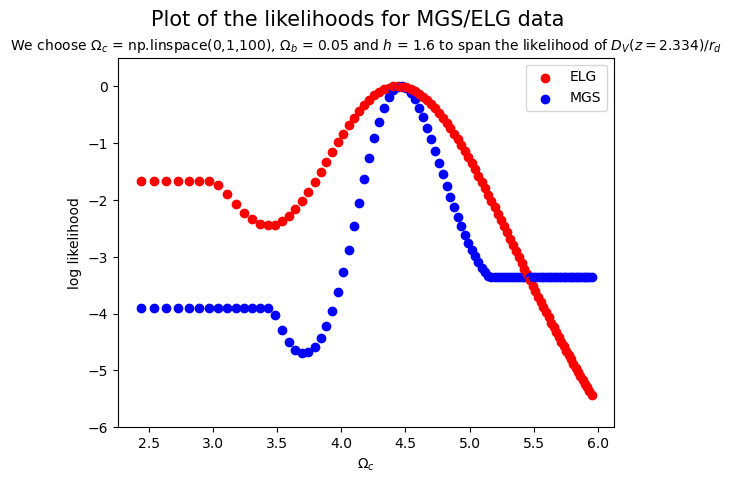

In [21]:
# PLOT THE log_likelihood_MGS/ELG(theta , df) FUNCTION

#We choose Omg_c = np.linspace(0,1,100), Omg_b = 0.05 and h = 1.6 to span the likelihood

for i in range(100):
    theta = [np.linspace(0,1,100)[i], 0.05, 1.6,0]
    Omg_r = (2.47e-5*1.6**-2)*1.6949484 # last factor due to neutrinos
    plt.scatter(D_V_H0([0.15,0.15],[np.linspace(0,1,100)[i] , 0.05 , 0 , Omg_r ,0,0])[0]/r_d_H0([np.linspace(0,1,100)[i] , 0.05 , 0 , Omg_r ,0,0],1.6),log_likelihood_MGS(theta,df_DV_MGS), color = "b")
    plt.scatter(D_V_H0([0.15,0.15],[np.linspace(0,1,100)[i] , 0.05 , 0 , Omg_r ,0,0])[0]/r_d_H0([np.linspace(0,1,100)[i] , 0.05 , 0 , Omg_r ,0,0],1.6),log_likelihood_DR16_ELG(theta,df_DV_DR16_ELG), color = "r")

plt.scatter( 4, 10, color = "r", label = "ELG")
plt.scatter( 4, 10, color = "b", label = "MGS")

plt.xlabel(r"$\Omega_c$")
plt.ylabel("log likelihood")
title_string = r"Plot of the likelihoods for MGS/ELG data"
subtitle_string = r"We choose $\Omega_c$ = np.linspace(0,1,100), $\Omega_b$ = 0.05 and $h$ = 1.6 to span the likelihood of $D_V(z=2.334)/r_d$"
plt.suptitle(title_string, y=0.98, fontsize=15)
plt.title(subtitle_string, fontsize=10)

plt.ylim(-6,0.5)
plt.legend()
plt.show()

/tmp/ipykernel_492862/618969643.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


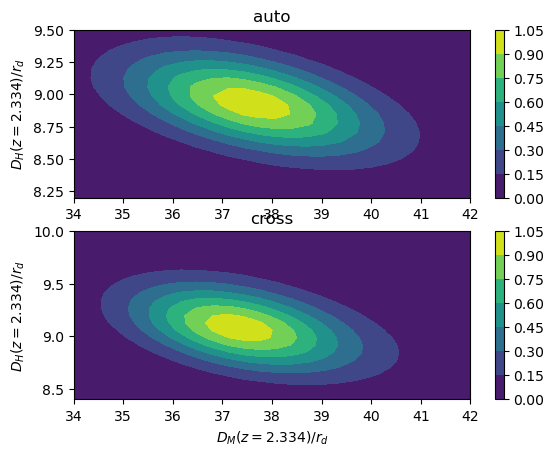

In [22]:
# PLOT THE log_likelihood_LYA(theta , df) FUNCTION

#We choose Omg_c = np.linspace(0,1,100), Omg_b = 0.05 and h = 1.6 to span the likelihood

fig, axs = plt.subplots(2)
plt.title(r"Likelihood for our LY-$\alpha$ data")

Z_val = df_DMDH_LYA_auto.pivot_table(index='D_M(z=2.334)/r_d', columns='D_H(z=2.334)/r_d', values='likelihood_ratio').T.values
X_unique = np.sort(df_DMDH_LYA_auto["D_M(z=2.334)/r_d"].unique())
Y_unique = np.sort(df_DMDH_LYA_auto["D_H(z=2.334)/r_d"].unique())
X_val, Y_val = np.meshgrid(X_unique, Y_unique)

axs[0].contourf(X_val,Y_val,Z_val)
axs[0].set_ylabel(r"$D_H(z=2.334)/r_d$")
axs[0].set_xlim(34,42)
axs[0].set_ylim(8.2,9.5)
axs[0].set_title("auto")
fig.colorbar(axs[0].contourf(X_val,Y_val,Z_val), orientation='vertical') # Color Bar

Z_val = df_DMDH_LYA_cross.pivot_table(index='D_M(z=2.334)/r_d', columns='D_H(z=2.334)/r_d', values='likelihood_ratio').T.values
X_unique = np.sort(df_DMDH_LYA_cross["D_M(z=2.334)/r_d"].unique())
Y_unique = np.sort(df_DMDH_LYA_cross["D_H(z=2.334)/r_d"].unique())
X_val, Y_val = np.meshgrid(X_unique, Y_unique)

axs[1].contourf(X_val,Y_val,Z_val)
axs[1].set_xlabel(r"$D_M(z=2.334)/r_d$")
axs[1].set_ylabel(r"$D_H(z=2.334)/r_d$")
axs[1].set_title("cross")
axs[1].set_xlim(34,42)
axs[1].set_ylim(8.4,10)
fig.colorbar(axs[1].contourf(X_val,Y_val,Z_val), orientation='vertical') # Color Bar


fig.show()

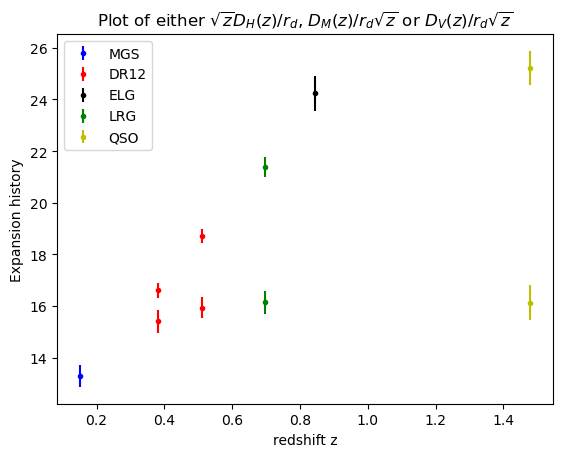

In [23]:
# Plot data BAO

# Recover data points with some error

# 1. Main Galaxy Sample

z_MGS = 0.15
# y is D_V/(r_d root(z))
y_MGS = np.max(np.array(df_DV_MGS["D_V_etc"]))*638.95/(148.69*np.sqrt(z_MGS))
# for now take error from paper
yerr_MGS = 25 / (148.69*np.sqrt(z_MGS))

# 2. DR12 BOSS Galaxies data

z_DR12 = np.array(df_DMDH_DR12[0])
y_DR12 = np.zeros(len(df_DMDH_DR12[0]))
err_DR12 = np.zeros(len(df_DMDH_DR12[0]))

for i in range(len(df_DMDH_DR12[0])):
    if df_DMDH_DR12[2][i] == "DM_over_rs":
        y_DR12[i] = np.array(df_DMDH_DR12[1][i])/np.sqrt(z_DR12[i])
        err_DR12[i] = np.sqrt(np.matrix(df_cov_DR12[i][i]))/np.sqrt(z_DR12[i])
    else:
        y_DR12[i] = np.array(df_DMDH_DR12[1][i])*np.sqrt(z_DR12[i])
        err_DR12[i] = np.sqrt(np.matrix(df_cov_DR12[i][i]))*np.sqrt(z_DR12[i])

# 3a. DR16 eBOSS ELGs

z_DR16_ELG = 0.845
y_DR16_ELG = np.max(np.array(df_DV_DR16_ELG[0]))/np.sqrt(z_DR16_ELG)
# for now take error from paper
yerr_DR16_ELG = 0.62/np.sqrt(z_DR16_ELG)

# 3b. DR16 eBOSS LRGs
z_DR16_LRG = np.array(df_DMDH_DR16_LRG[0])
y_DR16_LRG = np.zeros(len(df_DMDH_DR16_LRG[0]))
yerr_DR16_LRG = np.zeros(len(df_DMDH_DR16_LRG[0]))

for i in range(len(df_DMDH_DR16_LRG[0])):
    if df_DMDH_DR16_LRG[2][i] == "DM_over_rs":
        y_DR16_LRG[i] = np.array(df_DMDH_DR16_LRG[1][i])/np.sqrt(z_DR16_LRG[i])
        yerr_DR16_LRG[i] = np.sqrt(np.matrix(df_cov_DR16_LRG[i][i]))/np.sqrt(z_DR16_LRG[i])
    else:
        y_DR16_LRG[i] = np.array(df_DMDH_DR16_LRG[1][i])*np.sqrt(z_DR16_LRG[i])
        yerr_DR16_LRG[i] = np.sqrt(np.matrix(df_cov_DR16_LRG[i][i]))*np.sqrt(z_DR16_LRG[i])

# 3b. DR16 eBOSS LRGs
z_DR16_QSO = np.array(df_DMDH_DR16_QSO[0])
y_DR16_QSO = np.zeros(len(df_DMDH_DR16_QSO[0]))
yerr_DR16_QSO = np.zeros(len(df_DMDH_DR16_QSO[0]))

for i in range(len(df_DMDH_DR16_QSO[0])):
    if df_DMDH_DR16_QSO[2][i] == "DM_over_rs":
        y_DR16_QSO[i] = np.array(df_DMDH_DR16_QSO[1][i])/np.sqrt(z_DR16_QSO[i])
        yerr_DR16_QSO[i] = np.sqrt(np.matrix(df_cov_DR16_QSO[i][i]))/np.sqrt(z_DR16_QSO[i])
    else:
        y_DR16_QSO[i] = np.array(df_DMDH_DR16_QSO[1][i])*np.sqrt(z_DR16_QSO[i])
        yerr_DR16_QSO[i] = np.sqrt(np.matrix(df_cov_DR16_QSO[i][i]))*np.sqrt(z_DR16_QSO[i])
        
# Plot points

plt.errorbar(z_MGS, y_MGS, yerr=yerr_MGS, fmt=".b", capsize=0, label = r"MGS")
plt.errorbar(z_DR12, y_DR12, yerr=err_DR12, fmt=".r", capsize=0, label = r"DR12")
plt.errorbar(z_DR16_ELG , y_DR16_ELG , yerr=yerr_DR16_ELG , fmt=".k", capsize=0, label = r"ELG")
plt.errorbar(z_DR16_LRG , y_DR16_LRG , yerr=yerr_DR16_LRG , fmt=".g", capsize=0, label = r"LRG")
plt.errorbar(z_DR16_QSO , y_DR16_QSO , yerr=yerr_DR16_QSO , fmt=".y", capsize=0, label = r"QSO")

plt.title(r"Plot of either $\sqrt{z}D_H(z)/r_d$, $D_M(z)/r_d\sqrt{z}$ or $D_V(z)/r_d\sqrt{z}$")
plt.legend()
plt.xlabel("redshift z")
plt.ylabel("Expansion history");

# Processing the data

In [24]:
# Choose the seed parameters.
Omg_c_est = 0.3
h_est = 0.5
alpha_t_est = 1e-1
Omg_b_est = 0.05

In [25]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_c_est , Omg_b_est, h_est, alpha_t_est] + 1e-4 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_SNe, \
    [y_SNe, df_DV_MGS, df_DMDH_DR12, df_DV_DR16_ELG, df_DMDH_DR16_LRG, df_DMDH_DR16_QSO, df_DMDH_LYA_auto,df_DMDH_LYA_cross], \
    [cov_SNe, df_cov_DR12, df_cov_DR16_LRG, df_cov_DR16_QSO])
)
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_492862/4116172282.py:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omega_b*h**2)*x))), 1e-28, 1/(1+z_d()))[0]
  3%|█▏                                     | 32/1000 [08:33<4:42:22, 17.50s/it]Traceback (most recent call last):
  File "/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_492862/2053607270.py", line 12, in log_probability
    +log_likeliho

emcee: Exception while calling your likelihood function:
  params: [0.30395176 0.02621799 0.53334202 0.1154762 ]
  args: (array([0.01 , 0.051, 0.257, 0.012, 0.06 , 0.302, 0.014, 0.07 , 0.355,
       0.016, 0.082, 0.418, 0.019, 0.097, 0.491, 0.023, 0.114, 0.578,
       0.026, 0.134, 0.679, 0.031, 0.158, 0.799, 0.037, 0.186, 0.94 ,
       0.043, 0.218, 1.105, 1.3  ]), [array([32.9538, 36.6511, 40.5649, 33.879 , 37.158 , 40.9052, 33.8421,
       37.4301, 41.4214, 34.1185, 37.9566, 41.7909, 34.5934, 38.2532,
       42.2314, 34.939 , 38.6128, 42.617 , 35.252 , 39.0678, 43.0527,
       35.7485, 39.3414, 43.5041, 36.0697, 39.7921, 43.9725, 36.4345,
       40.1565, 44.514 , 44.8218]),      D_V_etc  chisquared
0     0.8015    7.803637
1     0.8025    7.707867
2     0.8035    7.740644
3     0.8045    7.781654
4     0.8055    7.825961
..       ...         ...
393   1.1945    6.614230
394   1.1955    6.637559
395   1.1965    6.660193
396   1.1975    6.682146
397   1.1985    6.703564

[398 rows x 2

KeyboardInterrupt: 

In [ ]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
labels = ["Omg_c", "Omg_b","h", "alpha_t"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True
);

plt.savefig('CornerPlot_GL4DEGB_4params_nucleosynth.pdf')

In [ ]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(4)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")
    ax[3].plot(samples_chain[i, :, 3], color = "black")


In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.15f}_{{-{1:.15f}}}^{{{2:.15f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
# --- PLOT DATA WITH ESTIMATED PARAMS -----

# BAO

# dataplt.legend()
plt.xlabel("redshift z")
plt.ylabel("Expansion history");

xl = np.linspace(0.001,3,int(1e2))
for Omg_c, Omg_b, h, alpha_t in flat_samples[np.random.randint(len(flat_samples), size=50)]:

    Omg_r = (2.47e-5*h**-2)*1.6949484 
    plt.plot(xl, np.sqrt(xl)*D_H_H0(xl,[Omg_c , Omg_b, 0 , Omg_r , alpha_t , 0])/r_d_H0([Omg_c , Omg_b, 0 , Omg_r , alpha_t , 0],h), color="k", alpha=0.1)
    plt.plot(xl, D_V_H0(xl,[Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="r", alpha=0.1)
    plt.plot(xl, D_M_H0(xl,[Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c ,Omg_b , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="b", alpha=0.1)


In [ ]:
# --- SNe: PLOT DATA WITH ESTIMATED PARAMS -----

xl = np.linspace(0.01,3,int(1e2))
for Omg_c,Omg_b, h, alpha_t in flat_samples[np.random.randint(len(flat_samples), size=100)]:

    H0 = 100*h
    Omg_r = (2.47e-5*h**-2)*1.6949484 
    mu_val = mu(D_L(xl, [Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0], H0))
    plt.plot(xl, np.array(mu_val), color="k", alpha=0.1)
    
plt.errorbar(x_SNe, y_SNe, yerr=np.array(np.sqrt(np.diag(cov_SNe))),ls = "none", linewidth=1, capsize=6, color = "b")
plt.scatter(x_SNe, y_SNe, s = 5, marker = "h", color = "b")

plt.xlabel("z")
plt.ylabel(r"$\mu(z)$");
plt.xscale("log")